In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import models

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

import kagglehub

In [ ]:
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

CT_ROOT = os.path.join(path, "Dataset", "Brain Tumor CT scan Images")
CT_TUMOR = os.path.join(CT_ROOT, "Tumor")
CT_HEALTHY = os.path.join(CT_ROOT, "Healthy")

print("CT dataset path:", CT_ROOT)

100%|██████████| 361M/361M [00:02<00:00, 166MB/s]

Extracting files...


CT dataset path: /root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1/Dataset/Brain Tumor CT scan Images


In [ ]:
classes = ["Healthy", "Tumor"]
ct_paths = []
ct_labels = []

for label, cls in enumerate(classes):
    folder = os.path.join(CT_ROOT, cls)
    print(f"Loading: {folder}")

    for f in os.listdir(folder):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            ct_paths.append(os.path.join(folder, f))
            ct_labels.append(label)

ct_paths = np.array(ct_paths)
ct_labels = np.array(ct_labels)

print("CT Total Images:", len(ct_paths))
print("Healthy:", np.sum(ct_labels == 0))
print("Tumor:", np.sum(ct_labels == 1))

Loading: /root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1/Dataset/Brain Tumor CT scan Images/Healthy
Loading: /root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1/Dataset/Brain Tumor CT scan Images/Tumor
CT Total Images: 4618
Healthy: 2300
Tumor: 2318


In [ ]:
# IMAGE_SIZE = 224

# def preprocess_ct(path):
#     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

#     # CLAHE contrast enhancement
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)

#     # Noise reduction
#     img = cv2.GaussianBlur(img, (3,3), 0)

#     # Z-score normalization
#     img = img.astype(np.float32)
#     img = (img - img.mean()) / (img.std() + 1e-6)

#     # Convert to 3-channel
#     img = np.stack([img, img, img], axis=-1)

#     return img

def preprocess_ct(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))

    # CLAHE to improve visibility
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Convert to float [0,1]
    img = img.astype(np.float32) / 255.0

    # Duplicate to 3 channels
    img = np.stack([img, img, img], axis=-1)

    # Apply ResNet ImageNet normalization
    img = (img - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])

    return img


In [ ]:
class CTDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = preprocess_ct(self.paths[idx])
        img = torch.tensor(img).permute(2, 0, 1).float()
        return img, self.labels[idx]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

def build_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(512, 2)
    return model.to(device)

Using device: cuda


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = {"acc": [], "f1": []}

best_overall_f1 = 0
best_overall_state = None

In [ ]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

print("\n=== Starting 5-Fold Cross-Validation (Optimized Params) ===\n")

fold_id = 1

for train_idx, val_idx in kf.split(ct_paths, ct_labels):

    print(f" FOLD {fold_id} ")

    X_train, X_val = ct_paths[train_idx], ct_paths[val_idx]
    y_train, y_val = ct_labels[train_idx], ct_labels[val_idx]

    train_ds = CTDataset(X_train, y_train)
    val_ds   = CTDataset(X_val,   y_val)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

    model = build_resnet18()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)

    best_fold_f1 = 0
    best_fold_state = None

    # -------- TRAIN LOOP --------
    for epoch in range(1, EPOCHS + 1):
        model.train()
        preds_all, labels_all = [], []

        for imgs, ys in train_loader:
            imgs, ys = imgs.to(device), ys.to(device)

            logits = model(imgs)
            loss = criterion(logits, ys)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = torch.argmax(logits, dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(ys.cpu().numpy())

        train_f1 = f1_score(labels_all, preds_all, zero_division=1)

        # -------- VALIDATION --------
        model.eval()
        val_preds, val_labels = [], []

        with torch.no_grad():
            for imgs, ys in val_loader:
                imgs, ys = imgs.to(device), ys.to(device)
                logits = model(imgs)
                preds = torch.argmax(logits, dim=1)

                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(ys.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, zero_division=1)

        print(f"[Fold {fold_id}] Epoch {epoch} | Train F1={train_f1:.3f} | Val F1={val_f1:.3f}")

        if val_f1 > best_fold_f1:
            best_fold_f1 = val_f1
            best_fold_state = model.state_dict()

    # Save fold model
    os.makedirs("ct_cv_models", exist_ok=True)
    torch.save(best_fold_state, f"ct_cv_models/ct_fold{fold_id}.pt")

    fold_results["acc"].append(val_acc)
    fold_results["f1"].append(best_fold_f1)

    if best_fold_f1 > best_overall_f1:
        best_overall_f1 = best_fold_f1
        best_overall_state = best_fold_state

    print(f" Fold {fold_id} BEST F1 = {best_fold_f1:.4f}")

    fold_id += 1

# Save best model
torch.save(best_overall_state, "ct_resnet18_best_5fold.pt")

print("5-Fold Training Complete")
print("Best Overall F1 Score:", best_overall_f1)


=== Starting 5-Fold Cross-Validation (Optimized Params) ===

 FOLD 1 
[Fold 1] Epoch 1 | Train F1=0.951 | Val F1=0.975
[Fold 1] Epoch 2 | Train F1=0.991 | Val F1=0.987
[Fold 1] Epoch 3 | Train F1=0.995 | Val F1=0.992
[Fold 1] Epoch 4 | Train F1=0.999 | Val F1=0.992
[Fold 1] Epoch 5 | Train F1=1.000 | Val F1=0.992
[Fold 1] Epoch 6 | Train F1=1.000 | Val F1=0.990
[Fold 1] Epoch 7 | Train F1=1.000 | Val F1=0.991
[Fold 1] Epoch 8 | Train F1=1.000 | Val F1=0.991
[Fold 1] Epoch 9 | Train F1=1.000 | Val F1=0.991
[Fold 1] Epoch 10 | Train F1=1.000 | Val F1=0.990
 Fold 1 BEST F1 = 0.9921
 FOLD 2 
[Fold 2] Epoch 1 | Train F1=0.954 | Val F1=0.986
[Fold 2] Epoch 2 | Train F1=0.992 | Val F1=0.982
[Fold 2] Epoch 3 | Train F1=0.995 | Val F1=0.989
[Fold 2] Epoch 4 | Train F1=0.997 | Val F1=0.986
[Fold 2] Epoch 5 | Train F1=0.999 | Val F1=0.995
[Fold 2] Epoch 6 | Train F1=1.000 | Val F1=0.990
[Fold 2] Epoch 7 | Train F1=1.000 | Val F1=0.994
[Fold 2] Epoch 8 | Train F1=1.000 | Val F1=0.995
[Fold 2] Epo

In [ ]:
best_model = build_resnet18()
best_model.load_state_dict(torch.load("ct_resnet18_best_5fold.pt"))
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class ResNetCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()

        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, inp, out):
        self.activations = out.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, x):
        out = self.model(x)
        class_idx = torch.argmax(out)

        self.model.zero_grad()
        out[0, class_idx].backward(retain_graph=True)

        A = self.activations[0]
        dA = self.gradients[0]

        weights = dA.mean(dim=[1,2])

        cam = torch.zeros_like(A[0])
        for c, w in enumerate(weights):
            cam += w * A[c]

        cam = F.relu(cam)
        cam = cam / (cam.max() + 1e-6)
        return cam.cpu().numpy()

In [ ]:
ct_cam = ResNetCAM(best_model, best_model.layer4[-1].conv2)

In [ ]:
def visualize_ct_cam(path, cam_obj):
    img = preprocess_ct(path)
    raw = img[...,0]
    raw_rgb = np.stack([raw, raw, raw], axis=-1)

    tensor = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().to(device)

    cam = cam_obj.generate(tensor)
    cam_resized = cv2.resize(cam, (224,224))

    heat = cv2.applyColorMap((cam_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(raw_rgb.astype(np.uint8), 0.5, heat, 0.5, 0)
    return raw_rgb, heat, overlay

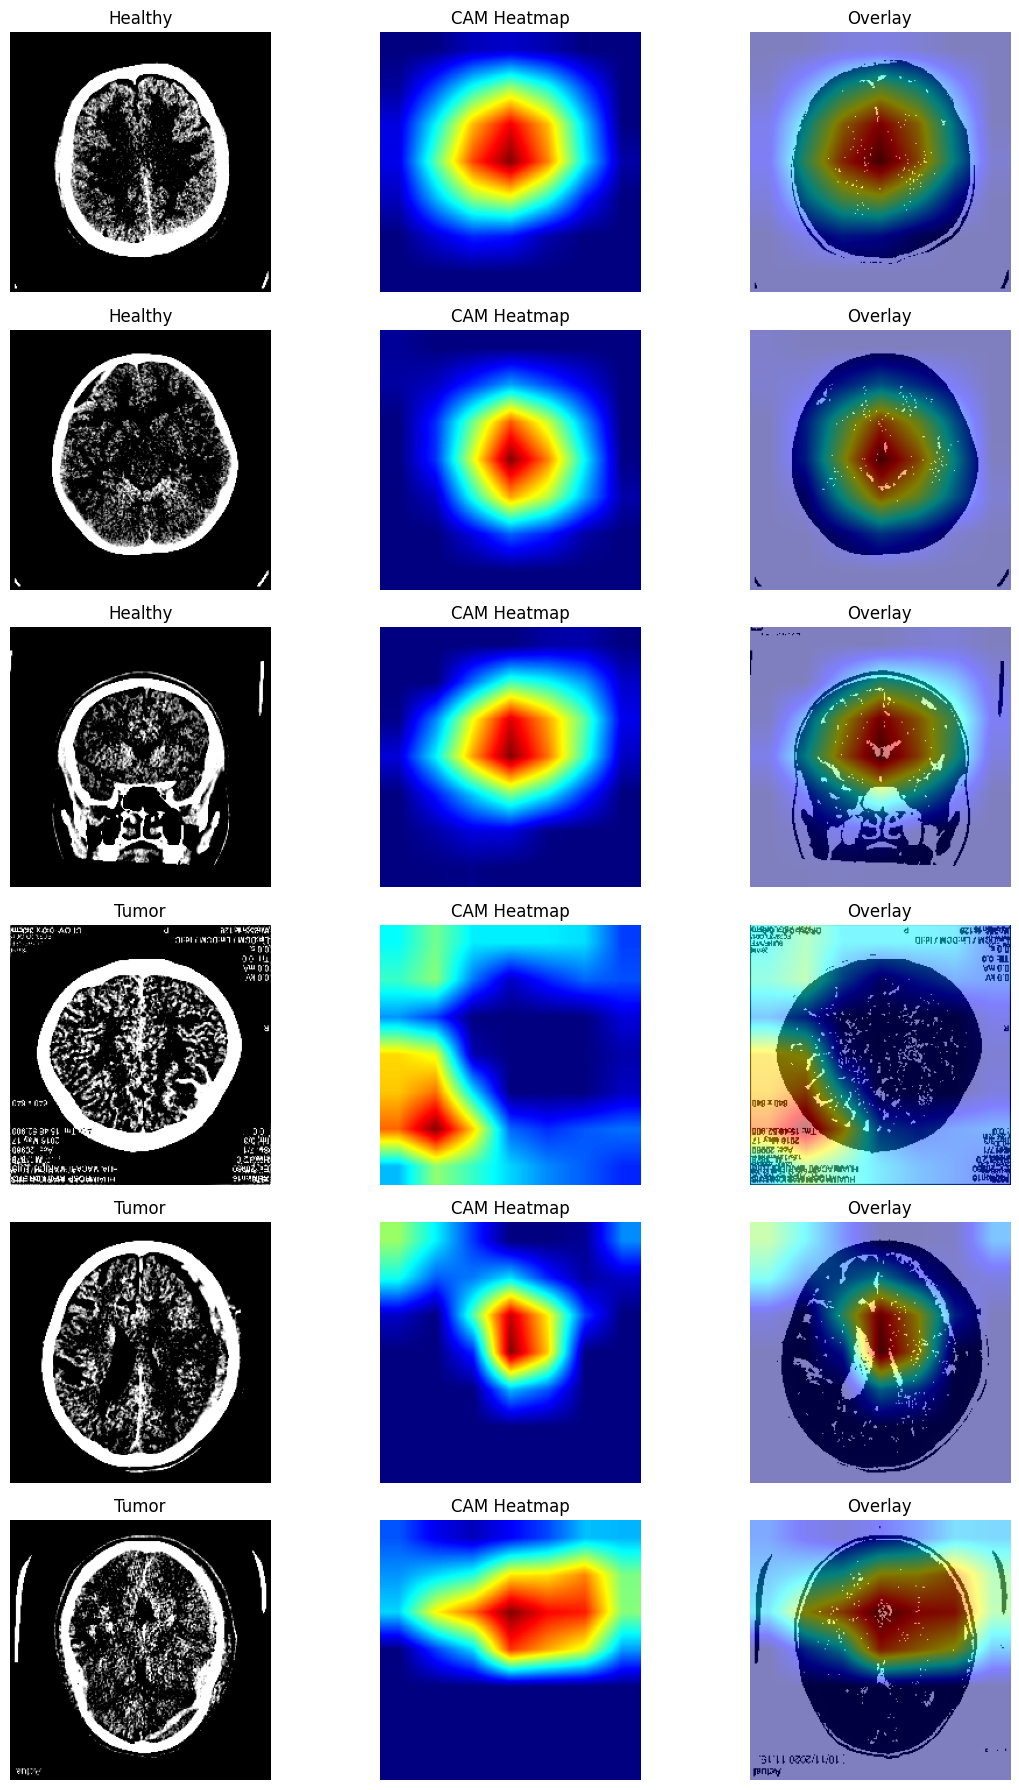

In [ ]:
healthy_idx = np.where(ct_labels == 0)[0]
tumor_idx   = np.where(ct_labels == 1)[0]

sample_paths = []
sample_paths += list(ct_paths[np.random.choice(healthy_idx, 3, replace=False)])
sample_paths += list(ct_paths[np.random.choice(tumor_idx, 3, replace=False)])

plt.figure(figsize=(12,18))

for i, p in enumerate(sample_paths):
    raw, heat, overlay = visualize_ct_cam(p, ct_cam)

    label = "Healthy" if i < 3 else "Tumor"

    plt.subplot(6,3,i*3+1); plt.imshow(raw, cmap="gray"); plt.title(label); plt.axis("off")
    plt.subplot(6,3,i*3+2); plt.imshow(heat); plt.title("CAM Heatmap"); plt.axis("off")
    plt.subplot(6,3,i*3+3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def compute_focus_score(cam):
    return np.mean(cam)

In [ ]:
from tqdm import tqdm
from scipy.stats import pearsonr

ct_focus_scores = []
ct_probabilities = []

best_model.eval()

for path in tqdm(ct_paths):
    img = preprocess_ct(path)
    tensor = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().to(device)

    # forward pass — get probability for tumor
    with torch.no_grad():
        logits = best_model(tensor)
        prob = torch.softmax(logits, dim=1)[0,1].item()

    # get CAM
    cam = ct_cam.generate(tensor)
    ct_focus_scores.append(np.mean(cam))
    ct_probabilities.append(prob)

ct_focus_scores = np.array(ct_focus_scores)
ct_probabilities = np.array(ct_probabilities)


100%|██████████| 4618/4618 [02:00<00:00, 38.43it/s]


In [ ]:
ct_focus_healthy = ct_focus_scores[ct_labels == 0]
ct_focus_tumor   = ct_focus_scores[ct_labels == 1]

/tmp/ipython-input-4251349952.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ct_focus_healthy, ct_focus_tumor], labels=["Healthy", "Tumor"])


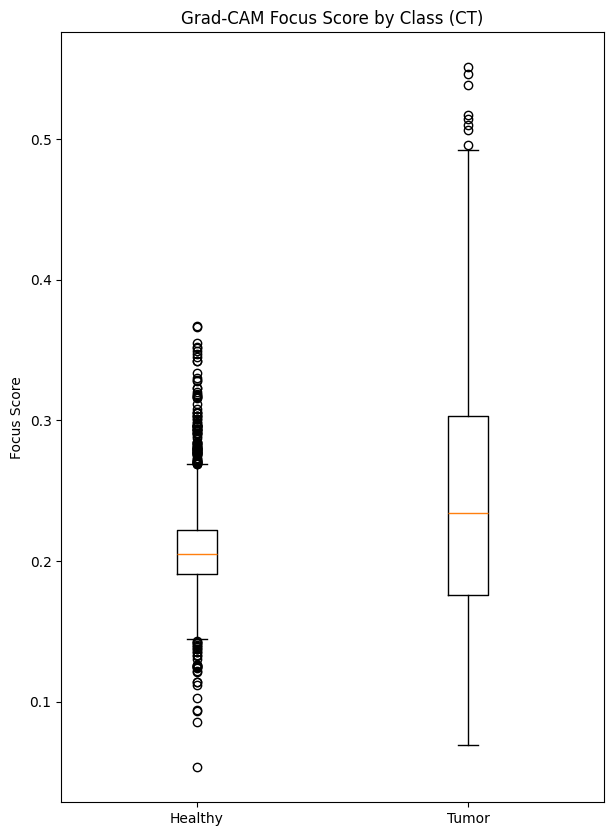

In [ ]:
plt.figure(figsize=(7,10))
plt.boxplot([ct_focus_healthy, ct_focus_tumor], labels=["Healthy", "Tumor"])
plt.title("Grad-CAM Focus Score by Class (CT)")
plt.ylabel("Focus Score")
plt.show()

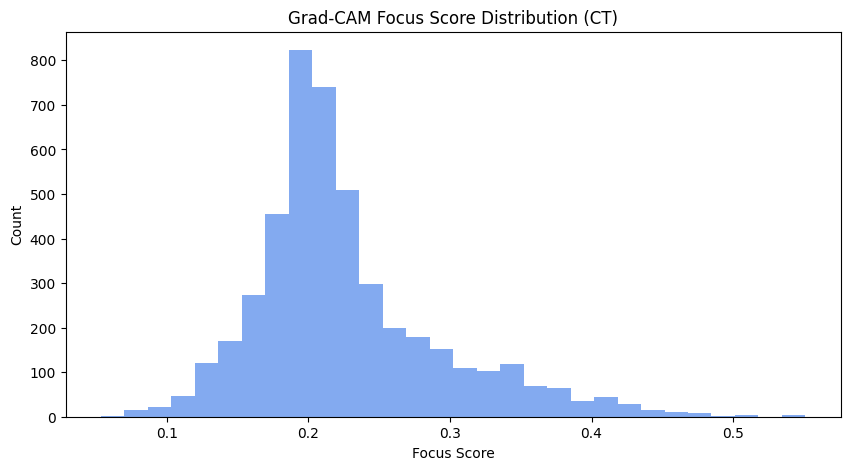

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(ct_focus_scores, bins=30, color="cornflowerblue", alpha=0.8)
plt.title("Grad-CAM Focus Score Distribution (CT)")
plt.xlabel("Focus Score")
plt.ylabel("Count")
plt.show()

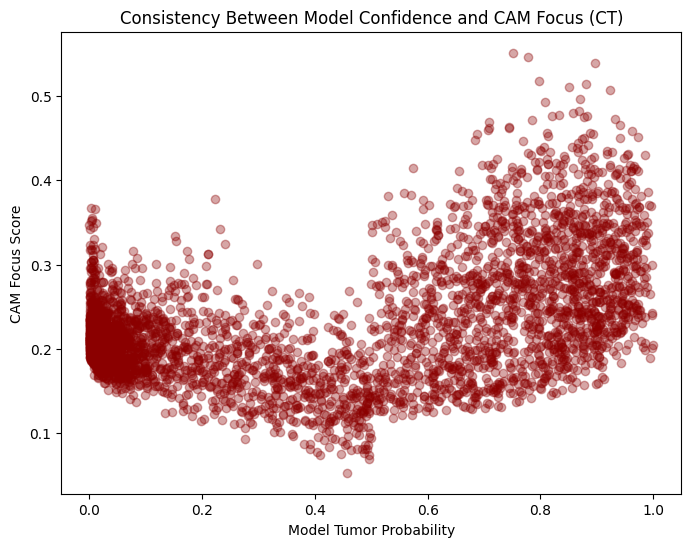

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(ct_probabilities, ct_focus_scores, alpha=0.35, color="darkred")
plt.title("Consistency Between Model Confidence and CAM Focus (CT)")
plt.xlabel("Model Tumor Probability")
plt.ylabel("CAM Focus Score")
plt.show()

In [ ]:
corr, _ = pearsonr(ct_probabilities, ct_focus_scores)

print("\n=== RESNET18 GRAD-CAM SUMMARY (CT) ===")
print(f"Mean CAM Score (ALL):      {ct_focus_scores.mean():.4f}")
print(f"Mean CAM Score (Healthy):  {ct_focus_healthy.mean():.4f}")
print(f"Mean CAM Score (Tumor):    {ct_focus_tumor.mean():.4f}")
print(f"\nCorrelation (CAM vs Tumor Confidence): {corr:.4f}")


=== RESNET18 GRAD-CAM SUMMARY (CT) ===
Mean CAM Score (ALL):      0.2264
Mean CAM Score (Healthy):  0.2085
Mean CAM Score (Tumor):    0.2442

Correlation (CAM vs Tumor Confidence): 0.4551
